# 3.1 多序列分类任务

前面的序列分类问题，一般都是单序列问题，但生物序列中，也存在大量的多序列分析预测任务。在自然语言任务中，其实也是类似的，如文本对的相似性判断任务等，也是多序列问题。

**多序列交互预测**任务是生物信息学中的一个重要研究方向，主要目的是通过分析和建模多个生物序列之间的相互作用来理解生物过程和分子机制。常见的多序列类型包括 DNA、RNA 和蛋白质序列。以下是对该任务的简要介绍：

---

### **1. 多序列交互预测的定义**
多序列交互预测任务旨在通过计算和算法方法，预测多个生物分子（如 DNA、RNA 和蛋白质）之间的物理或功能性相互作用。例如：
- **蛋白质-蛋白质交互（PPI）**：预测两种或多种蛋白质是否会形成复合物或协同工作。
- **RNA-蛋白质交互（RPI）**：预测 RNA 和蛋白质之间的结合位点或结合强度。
- **DNA-蛋白质交互**：预测转录因子与 DNA 的结合位置和作用强度。

---

### **2. 任务的重要性**
- **理解分子机制**：
  - 生物分子之间的相互作用是许多生物过程的基础，例如信号转导、转录调控和代谢。
- **药物研发**：
  - 通过预测靶向蛋白质的相互作用，设计小分子药物或生物大分子药物。
- **疾病研究**：
  - 某些疾病（如神经退行性疾病）与分子间异常交互有关，预测交互可揭示潜在机制。

---

### **3. 常见的多序列交互类型**

#### **（1）蛋白质-蛋白质交互（Protein-Protein Interaction, PPI）**
- **目标**：预测两种或多种蛋白质是否会形成复合物或相互作用。
- **挑战**：
  - 蛋白质结构的高维复杂性。
  - 动态交互（不同条件下的交互行为）。
- **应用**：
  - 生物通路建模。
  - 疾病相关蛋白预测。

#### **（2）RNA-蛋白质交互（RNA-Protein Interaction, RPI）**
- **目标**：预测 RNA 和蛋白质之间的结合位置、强度或调控作用。
- **挑战**：
  - RNA 的二级结构和序列依赖性。
  - 蛋白质与 RNA 的结合位点特异性。
- **应用**：
  - 非编码 RNA 功能研究。
  - 转录后调控机制。

#### **（3）DNA-蛋白质交互（DNA-Protein Interaction, DPI）**
- **目标**：预测 DNA 上的结合位点或转录因子与 DNA 的作用强度。
- **挑战**：
  - 转录因子识别序列的特异性和冗余性。
  - 环境因素（如染色质结构）对结合的影响。
- **应用**：
  - 基因调控网络构建。
  - 基因编辑靶点预测。

#### **（4）其他交互**
- DNA-RNA 交互。
- 蛋白质-小分子交互。
- 蛋白质-多肽交互。


### **4. 数据集与基准**

#### **（1）蛋白质-蛋白质交互**
- **数据集**：
  - STRING：全面的蛋白质交互数据库。
  - BioGRID：实验验证的交互数据库。

#### **（2）RNA-蛋白质交互**
- **数据集**：
  - RPI369：RNA-蛋白质交互数据集。
  - NPInter：实验验证的 RNA-蛋白质交互。

#### **（3）DNA-蛋白质交互**
- **数据集**：
  - JASPAR：转录因子结合位点。
  - ChIP-seq 数据：从实验中获取 DNA-蛋白质交互信息。


### **5. 课程数据集**

本例程使用了相对简单的蛋白质编码数据集，也就是sentence1是DNA序列，sentence2是对应编码后的蛋白质序列。

也就是我们一般中学就学过的三联密码子。
每 3 个DNA核苷酸组成一个密码子，编码一个蛋白质氨基酸。
共有 64 种密码子，其中 61 种编码氨基酸，3 种为终止密码子。

数据集来自lucaone的论文。


In [2]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value


# import os

# # 设置环境变量
# os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# # 打印环境变量以确认设置成功
# print(os.environ.get('HF_ENDPOINT'))

In [8]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer
import evaluate
import numpy as np
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification


# 假设你的JSON文件名为 'data.json' 并且每行是一个独立的JSON对象
raw_datasets = load_dataset('dnagpt/gene_lan_transfer', 'dna_protein_pair')["train"].train_test_split(test_size=0.1, shuffle=True)  # 或者指定特定语言如 'zh' 表示中文,https://huggingface.co/datasets/google-research-datasets/paws-x

#分词器
tokenizer = AutoTokenizer.from_pretrained("dnagpt/gene_eng_gpt2_v0")
tokenizer.pad_token = tokenizer.eos_token

# 修改分词器的填充方向为左侧，默认右侧，分类问题可以是左侧
#tokenizer.padding_side = "left"


In [9]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 3600
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 400
    })
})

In [10]:
raw_datasets["train"][0]

{'sentence1': 'ATGGACTTGCAGAATTATTCCTTTGTGTCAGAATTTATATTGCATGGACTCTGCAATTCACGGAATCTCCAAATGTTTTTCTTTGTATTCTTCTCTGGAATCTATTTAGCCATTGTGCTGGGTAACCTCCTCATTGTAGTCACTGTCATTTTTGACCCTCGCTTGCACTCTTCCCCTATGTACTTCCTGCTGGGGAACTTATCTTTCCTTGACATGTGGCTGGCTTCATTTGCCACACCCAAGATGATCAGGGATTTTCTTAGTGATCGAAAGCTTATCTCCTTTGGGGGATGCATGGCTCAAATCTTCTTCTTGCACTTTATTGGTGGGGCTGAGATGATACTGCTGGTTTCCATGGCCTATGACAGGTATGTGGCCATATGCAAACCCTTGCATTATATGACTGTGATGAATCGGAGGACTTGCATTGGGCTGGTGCTGATTTCATGGACTATAGGATTTGTGCACTCCATCAGTCAAGTAGCTTTCACTGTGAATTTACCTTACTGTGGCCCCAATGAGGTGGACAGCTTCTTTTGTGATCTCCCTTTGGTGATCAAACTTGCTTGCAGGGACACCTATGTCTTAGGCATACTTATGATCTCAGACAGTGGGTTGCTTTCTATGAGTTGTTTTCTGCTCCTCATGATCTCCTACACAGTTATCCTTGTCACTGTGCAACAGCATGCTGCTGGTGGCGTCTCCAAAGCACTATCTACTTGCTCTGCTCACATTATGGTTGTCACACTTTTCTTTGGGCCTTGCATATTCATTTATGTGTGGCCTTTCAGTAGGTTCTCTGTGGATAAGGTCTTGTCTGTGTTTTACACAATTTTTACTCCACTTCTGAATCCCCTAATCTACACGTTGAGAAATGAAGAGATGAAAGCAGCCATGAAGAAACTGTGGAACCGACACGTGACTTTTCAC',
 'sentence2': 'MDLQNYSFVSEFILHGLCNSRNLQMFFFVFFSGIYLA

In [12]:
print(tokenizer.tokenize(raw_datasets["train"][0]["sentence1"], raw_datasets["train"][0]["sentence2"]))

['ATGG', 'ACTTGC', 'AGAA', 'TTATTCC', 'TTTGTG', 'TCAGAA', 'TTTA', 'TATTGC', 'ATGGACTC', 'TGCAATTC', 'ACGG', 'AATCTCC', 'AAATGTTTT', 'TCTTTG', 'TATTCTTC', 'TCTGG', 'AATCTATT', 'TAGCC', 'ATTG', 'TGCTGGG', 'TAACCTCC', 'TCATTG', 'TAG', 'TCACTG', 'TCATTTTTG', 'ACCC', 'TCGC', 'TTGC', 'ACTC', 'TTCCCC', 'TATGTAC', 'TTCCTGC', 'TGGGGAAC', 'TTATC', 'TTTCCTTG', 'ACATG', 'TGGCTGGC', 'TTCATT', 'TGCC', 'ACACCC', 'AAG', 'ATGATC', 'AGGG', 'ATTTTC', 'TTAGTG', 'ATCGAA', 'AGC', 'TTATC', 'TCCTTTG', 'GGGG', 'ATGC', 'ATGGC', 'TCAAATC', 'TTCTTC', 'TTGC', 'ACTT', 'TATTGG', 'TGGGGC', 'TGAGATG', 'ATAC', 'TGCTGG', 'TTTCC', 'ATGGCC', 'TATG', 'ACAGG', 'TATG', 'TGGCC', 'ATATGCAA', 'ACCCTTGC', 'ATTATA', 'TGAC', 'TGTGATG', 'AATC', 'GGAGG', 'ACTTGC', 'ATTGGGC', 'TGGTGC', 'TGATT', 'TCATGG', 'ACTATAGG', 'ATTTGTGC', 'ACTCCATC', 'AGTC', 'AAGTAGC', 'TTTC', 'ACTGTG', 'AATTTACC', 'TTACTG', 'TGGCCCC', 'AATG', 'AGGTGG', 'ACAGC', 'TTCTTTTG', 'TGATC', 'TCCC', 'TTTGG', 'TGATC', 'AAAC', 'TTGCTTGC', 'AGGGACACC', 'TATG', 'TCTTAGGC', 

In [13]:
token_len_list = []
for item in raw_datasets["test"]:
    inputs = tokenizer.tokenize(item["sentence1"], item["sentence2"])
    token_len_list.append( len(inputs) )

mean_len = sum(token_len_list)/len(token_len_list)
min_len  = min(token_len_list)
max_len = max(token_len_list)

print("dna datasets ", "mean token lenght", mean_len, "min token length", min_len, "max token length", max_len)

dna datasets  mean token lenght 242.49 min token length 44 max token length 466


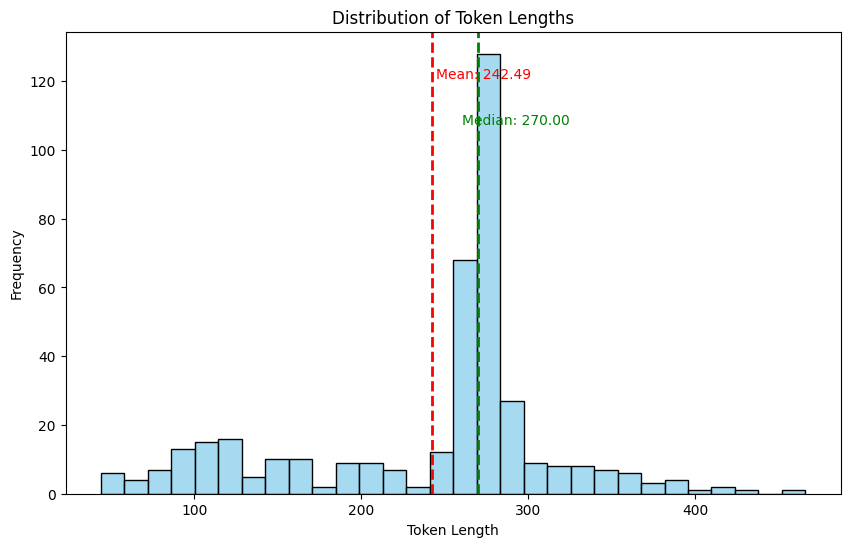

In [14]:
#统计图
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 假设这是您的 token_len_list

# 设置画布大小
plt.figure(figsize=(10, 6))

# 使用 seaborn 生成直方图
sns.histplot(token_len_list, bins=30, kde=False, color="skyblue", edgecolor="black")

# 添加标题和标签
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")

# 显示平均值线
mean_value = np.mean(token_len_list)
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_value + 2, plt.ylim()[1]*0.9, f'Mean: {mean_value:.2f}', color='red')

# 显示中位数线
median_value = np.median(token_len_list)
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2)
plt.text(median_value - 10, plt.ylim()[1]*0.8, f'Median: {median_value:.2f}', color='green')

# 显示图形
plt.show()

In [17]:
#2 分词函数
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True,max_length=512, padding="max_length")

#3 构建分词后的数据集
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

#4 训练数据构建
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [18]:
#模型定义，文本分类模型
model = AutoModelForSequenceClassification.from_pretrained("dnagpt/gene_eng_gpt2_v0", num_labels=2)
model.config.pad_token_id = model.config.eos_token_id
model

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at dnagpt/gene_eng_gpt2_v0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(90000, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [20]:
#指标函数定义
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': (predictions==labels).sum() / len(labels)}


training_args = TrainingArguments(
    output_dir="ds_job_multi",
    learning_rate=1e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_ratio=0.1,
    optim='adamw_torch',
    weight_decay=0.0,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=20,
    num_train_epochs=8, #训练多少轮
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/root/miniconda3/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4640/2967080251.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[2024-12-30 22:43:54,582] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/root/miniconda3/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/root/miniconda3/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/root/miniconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/root/miniconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCXX_3.4'
/root/minicond

In [21]:
trainer.train() #模型训练

TrainOutput(global_step=1440, training_loss=0.3017331454488966, metrics={'train_runtime': 509.1802, 'train_samples_per_second': 56.562, 'train_steps_per_second': 2.828, 'total_flos': 7525346417049600.0, 'train_loss': 0.3017331454488966, 'epoch': 8.0})

In [22]:
#模型测试
import evaluate
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)
metric = evaluate.load("glue", "mrpc")
ret = metric.compute(predictions=preds, references=predictions.label_ids)
ret

{'accuracy': 0.8575, 'f1': 0.8503937007874016}

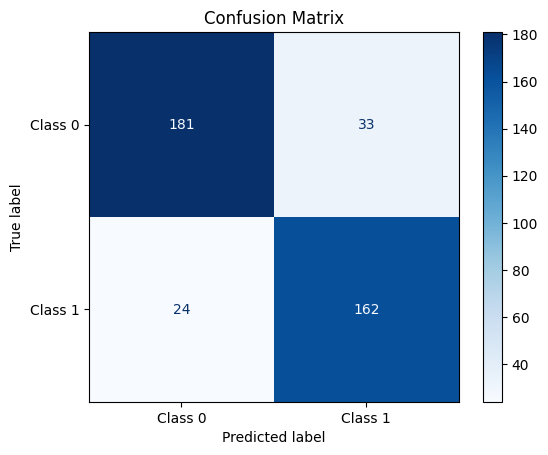

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 假设 predictions.label_ids 是真实的标签，preds 是模型的预测
cm = confusion_matrix(predictions.label_ids, preds)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()